# <u>Facial Keypoints Detection
Detection of facial keypoints is very useful for a number of tasks like facial recognition, detection etc. The keypoints selected in this code uses 15 keypoints representing the various coordinates on the human face. This is a regression problem because we are predicting the coordinates for the landmarks on the face. CNN was used for this problem. The model achieved an accuracy of 76% on the validation set.

In [1]:
# import the required packages
from skimage.io import imread
from skimage.transform import resize
import os
import cv2 
import numpy as np
from tqdm import tqdm 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from sklearn.utils import shuffle

%matplotlib inline

## <u>Data loading and Preprocessing
The x and y coordinates have been given in the dataset for roughly 2000 greyscale images.<br>
For the preprocessing part we will scale the coordinates such that they lie in the range [-0.5, 0.5].

In [2]:
# for loading the data
def load_data(dirname, test=False):
    # read the csv data
    data = pd.read_csv(dirname)
    # drop the missing value rows 
    data = data.dropna()

    # convert the string pixels values into an matix
    data['Image'] = data['Image'].apply(lambda img: np.fromstring(img, sep=' ')).values 

    # convert the string image data to float
    imgs = np.vstack(data['Image'].values)/255
    # reshape the matrix
    imgs = imgs.reshape(data.shape[0], 96, 96)
    # convert to float
    imgs = imgs.astype(np.float32)
    
    if test == False:
        # extract the points 
        points = data[data.columns[:-1]].values

        # scale the points [-0.5,0.5]
        points = points/96 - 0.5
        # convert it to float
        points = points.astype(np.float32)
    
    # shuffle the data
    imgs, points = shuffle(imgs, points)
    
    return imgs, points

In [3]:
# training data
imgs_train, points_train = load_data(dirname = 'data/training.csv')

In [4]:
# testing data
imgs_test, points_test = load_data(dirname = 'data/test.csv')

In [5]:
print('Training image data: ' + str(imgs_train.shape))
print('Training points data: ' + str(points_train.shape))

Training image data: (2140, 96, 96)
Training points data: (2140, 30)


In [6]:
print('Testing image data: ' + str(imgs_test.shape))
print('Testing points data: ' + str(points_test.shape))

Testing image data: (1783, 96, 96)
Testing points data: (1783, 1)


In [189]:
points[0][:]

array([0.68559724, 0.38600346, 0.29375   , 0.38810068, 0.6017778 ,
       0.39019445, 0.77779514, 0.38810068, 0.3901389 , 0.39438543,
       0.2078368 , 0.40276736, 0.57872915, 0.30637848, 0.8301805 ,
       0.3294271 , 0.41109374, 0.30847222, 0.14287847, 0.37552777,
       0.5116736 , 0.6060243 , 0.70445484, 0.7506111 , 0.30213195,
       0.75270486, 0.50748265, 0.7149861 , 0.5116736 , 0.90776736],
      dtype=float32)

array([ 0.20547748, -0.12158559, -0.2051982 , -0.09742343,  0.1169009 ,
       -0.11353153,  0.2537928 , -0.11755856, -0.1609099 , -0.0934054 ,
       -0.28974774, -0.08132432,  0.0565045 , -0.18198198,  0.286     ,
       -0.22627027, -0.15688288, -0.186     , -0.3622162 , -0.17795496,
        0.01624324,  0.06764865,  0.17327027,  0.28506306, -0.14077477,
        0.30921623,  0.01221622,  0.23674774,  0.0242973 ,  0.3655856 ],
      dtype=float32)

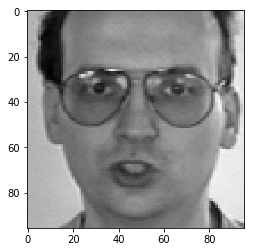

In [23]:
plt.imshow(np.squeeze(imgs_train[1]), cmap='gray')
points_train[0]

## <u>Data Visualization
We will now look at some images with keypoints plotted on them

In [26]:
# plots keypoints on face image
def plot_keypoints(img, points):
    # display image
    plt.imshow(img, cmap='gray')
    # plot the keypoints
    for i in range(0,30,2):
        plt.scatter((points[i] + 0.5)*96, (points[i+1]+0.5)*96, color='red')

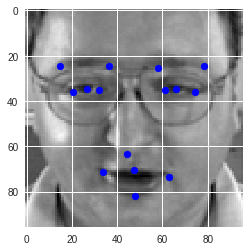

In [153]:
id = 59
plot_keypoints(imgs_train[id], points_train[id])

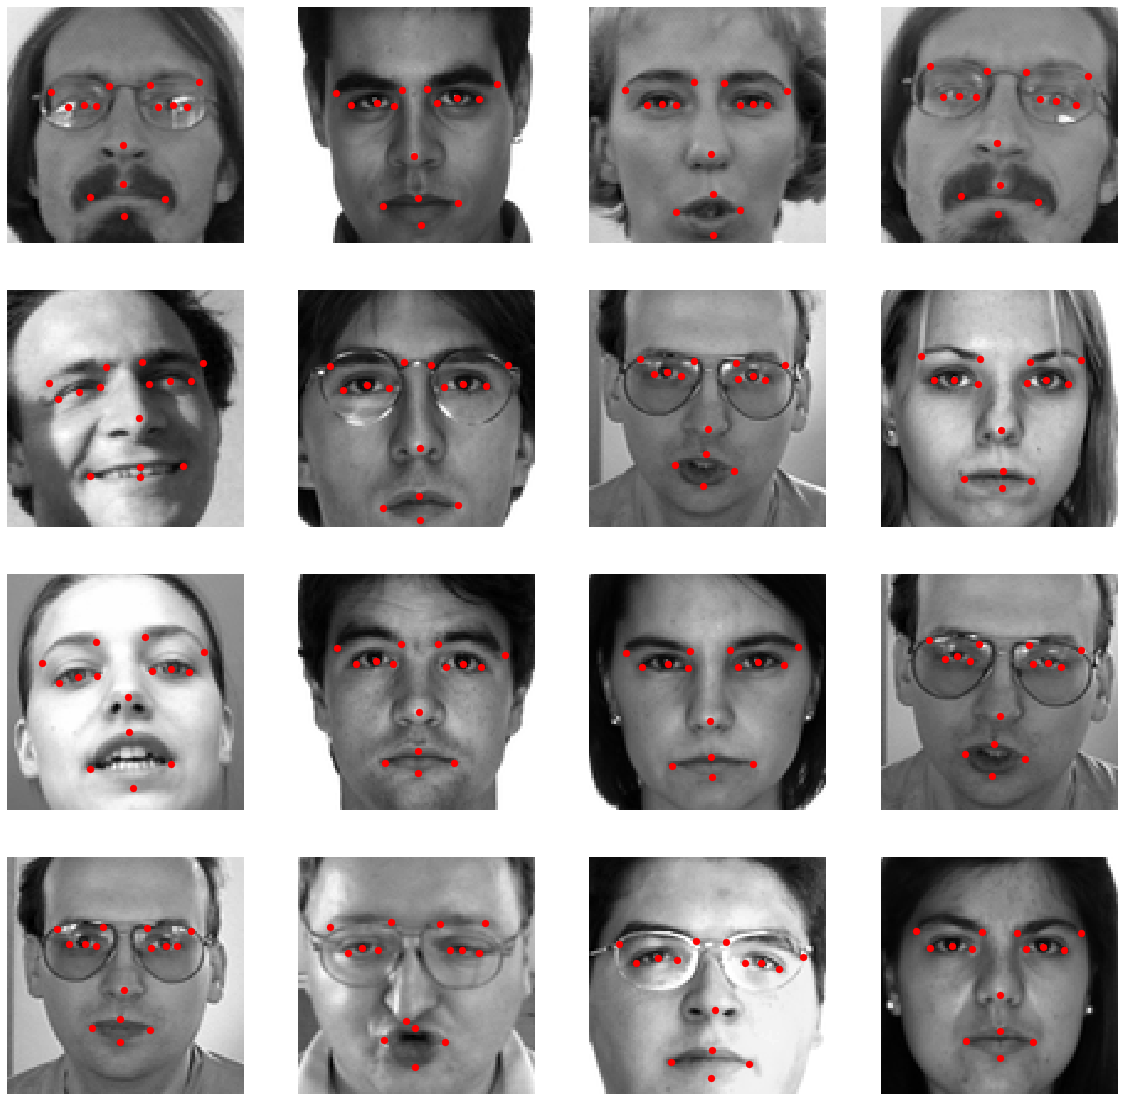

In [157]:
fig = plt.figure(figsize=(20,20))
for i in range(16):
    fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_keypoints(imgs_train[i], points_train[i])
plt.show()

## <u>Data augmentation
We will augment some data since the training set is quite small. We will augment by flipping the image vertically

In [0]:
# does data augmentation by flipping the image
def augment_data(img, points):
    rows, cols = img.shape
    new_img = np.copy(img)
    
    # flip the image
    for i in range(96):
        for j in range(48):
            temp = img[i][j]
            new_img[i][j] = img[i][cols-j-1]
            new_img[i][cols-j-1] = temp
            
    # flip the points
    new_points = np.copy(points)
    for i in range(0,30,2):
        new_points[i] = -points[i]
        
    return new_img, new_points

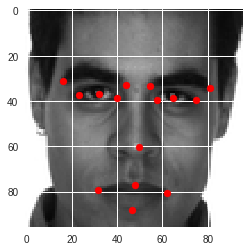

In [159]:
flip_img, flip_points = augment_data(imgs_train[1], points_train[1])
plot_keypoints(flip_img, flip_points)

Now we will augment images and add them to the training dataset

In [128]:
aug_imgs_train = []
aug_points_train = []

# apply flipping operation
for i in tqdm(range(0,imgs_train.shape[0])):
    aug_img, aug_point = flip_img(imgs_train[i], points_train[i])
     # original data
    aug_imgs_train.append(imgs_train[i])
    aug_points_train.append(points_train[i]) 
    
    # augmented data
    aug_imgs_train.append(aug_img)
    aug_points_train.append(aug_point) 

# convert to numpy
aug_imgs_train = np.array(aug_imgs_train)   
aug_points_train = np.copy(aug_points_train)

print(aug_imgs_train.shape)
print(aug_points_train.shape)

100%|██████████| 2033/2033 [00:12<00:00, 161.45it/s]

(4066, 96, 96)
(4066, 30)


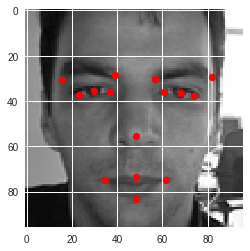

In [160]:
# visualization
id = 28
plot_keypoints(imgs_train[id], points_train[id])

In [ ]:
# visualization
plot_keypoints(aug_imgs_train[id], aug_points_train[id])

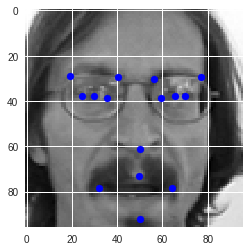

In [131]:
# visualization
plot_keypoints(aug_imgs_train[id+1], aug_points_train[id+1])

# <u>Training
For training we will be using a CNN with 30 output neurons. 

In [17]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import ModelCheckpoint, History
from keras.optimizers import Adam
from keras.models import load_model

In [145]:
# reshape the images for training
aug_imgs_train = aug_imgs_train.reshape(aug_imgs_train.shape[0], 96, 96, 1)
imgs_val = imgs_val.reshape(imgs_val.shape[0], 96, 96, 1)

## <u>Model Architecture

In [7]:
# model checkpoint 
checkpoint = ModelCheckpoint('drive/Colab Notebooks/best_weights.h5', verbose=1, save_best_only=True)
hist = History()

# model architecture
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(96, 96, 1)))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(30))
model.summary()
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         73856     
__________

In [8]:
# load already saved model weights if it exists
model.load_weights('model/best_weights.h5')

In [180]:
# training the model
hist = model.fit(imgs.reshape(imgs.shape[0], 96, 96, 1), points, validation_split=0.2, batch_size=64, callbacks=[checkpoint, hist],
          shuffle=True, epochs=150, verbose=1)

# save the model weights
model.save_weights('drive/Colab Notebooks/weights.h5')
# save the model
model.save('drive/Colab Notebooks/model.h5')

Train on 1712 samples, validate on 428 samples
Epoch 1/150
1712/1712 [==============================] - 1s 569us/step - loss: 4.2055e-04 - acc: 0.7792 - val_loss: 6.0044e-04 - val_acc: 0.7453

Epoch 00001: val_loss improved from 0.00060 to 0.00060, saving model to drive/Colab Notebooks/best_weights.h5
Epoch 2/150
1712/1712 [==============================] - 1s 529us/step - loss: 4.1276e-04 - acc: 0.7704 - val_loss: 6.1212e-04 - val_acc: 0.7570

Epoch 00002: val_loss did not improve from 0.00060
Epoch 3/150
1712/1712 [==============================] - 1s 498us/step - loss: 4.1872e-04 - acc: 0.7856 - val_loss: 6.1897e-04 - val_acc: 0.7453

Epoch 00003: val_loss did not improve from 0.00060
Epoch 4/150
1712/1712 [==============================] - 1s 532us/step - loss: 4.1250e-04 - acc: 0.7716 - val_loss: 6.0914e-04 - val_acc: 0.7523

Epoch 00004: val_loss did not improve from 0.00060
Epoch 5/150
1712/1712 [==============================] - 1s 532us/step - loss: 4.0722e-04 - acc: 0.7728 - 

  64/1712 [>.............................] - ETA: 0s - loss: 3.1297e-04 - acc: 0.79691712/1712 [==============================] - 1s 524us/step - loss: 3.3120e-04 - acc: 0.7944 - val_loss: 5.8859e-04 - val_acc: 0.7477

Epoch 00040: val_loss did not improve from 0.00058
Epoch 41/150
1712/1712 [==============================] - 1s 531us/step - loss: 3.3154e-04 - acc: 0.7810 - val_loss: 6.0050e-04 - val_acc: 0.7430

Epoch 00041: val_loss did not improve from 0.00058
Epoch 42/150
1712/1712 [==============================] - 1s 526us/step - loss: 3.3096e-04 - acc: 0.7909 - val_loss: 5.7891e-04 - val_acc: 0.7547

Epoch 00042: val_loss improved from 0.00058 to 0.00058, saving model to drive/Colab Notebooks/best_weights.h5
Epoch 43/150
1712/1712 [==============================] - 1s 549us/step - loss: 3.2793e-04 - acc: 0.7961 - val_loss: 6.1247e-04 - val_acc: 0.7220

Epoch 00043: val_loss did not improve from 0.00058
Epoch 44/150
1712/1712 [==============================] - 1s 528us/step - los

 320/1712 [====>.........................] - ETA: 0s - loss: 2.7056e-04 - acc: 0.82191712/1712 [==============================] - 1s 540us/step - loss: 2.7940e-04 - acc: 0.8078 - val_loss: 5.7046e-04 - val_acc: 0.7313

Epoch 00084: val_loss did not improve from 0.00056
Epoch 85/150
1712/1712 [==============================] - 1s 520us/step - loss: 2.7031e-04 - acc: 0.8067 - val_loss: 5.6953e-04 - val_acc: 0.7453

Epoch 00085: val_loss did not improve from 0.00056
Epoch 86/150
1712/1712 [==============================] - 1s 534us/step - loss: 2.5893e-04 - acc: 0.8043 - val_loss: 5.7063e-04 - val_acc: 0.7500

Epoch 00086: val_loss did not improve from 0.00056
Epoch 87/150
1712/1712 [==============================] - 1s 530us/step - loss: 2.5439e-04 - acc: 0.8037 - val_loss: 5.5957e-04 - val_acc: 0.7617

Epoch 00087: val_loss improved from 0.00056 to 0.00056, saving model to drive/Colab Notebooks/best_weights.h5
Epoch 88/150
1712/1712 [==============================] - 1s 561us/step - los

  64/1712 [>.............................] - ETA: 0s - loss: 2.4630e-04 - acc: 0.76561712/1712 [==============================] - 1s 535us/step - loss: 2.2480e-04 - acc: 0.8172 - val_loss: 5.5685e-04 - val_acc: 0.7547

Epoch 00129: val_loss did not improve from 0.00054
Epoch 130/150
1712/1712 [==============================] - 1s 525us/step - loss: 2.1961e-04 - acc: 0.8289 - val_loss: 5.4759e-04 - val_acc: 0.7523

Epoch 00130: val_loss did not improve from 0.00054
Epoch 131/150
1712/1712 [==============================] - 1s 531us/step - loss: 2.1917e-04 - acc: 0.8084 - val_loss: 5.6663e-04 - val_acc: 0.7617

Epoch 00131: val_loss did not improve from 0.00054
Epoch 132/150
1712/1712 [==============================] - 1s 528us/step - loss: 2.1735e-04 - acc: 0.8172 - val_loss: 5.4458e-04 - val_acc: 0.7477

Epoch 00132: val_loss did not improve from 0.00054
Epoch 133/150
1712/1712 [==============================] - 1s 523us/step - loss: 2.2108e-04 - acc: 0.8283 - val_loss: 5.4792e-04 - va

## Graph Plots
Let us look at some graph plots. We have two plots one for Loss and the other for accuracy.

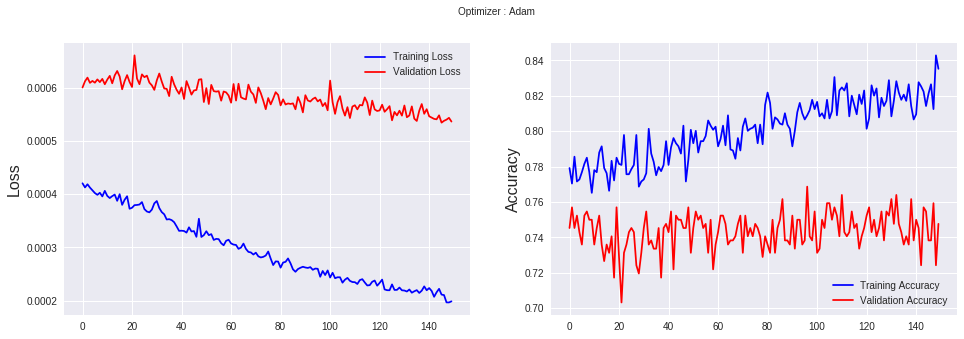

In [181]:
# loss plot 
plt.figure(figsize=(16,5))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], color='b', label='Training Loss')
plt.plot(hist.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

# accuracy plot
plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['acc'], color='b', label='Training Accuracy')
plt.plot(hist.history['val_acc'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# for saving image of model architecture
from keras.utils.vis_utils import plot_model
import os

os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Test Results
Let us look at the performance of the model on some unseen images. The model performs very well detecting the keypoints on the face.

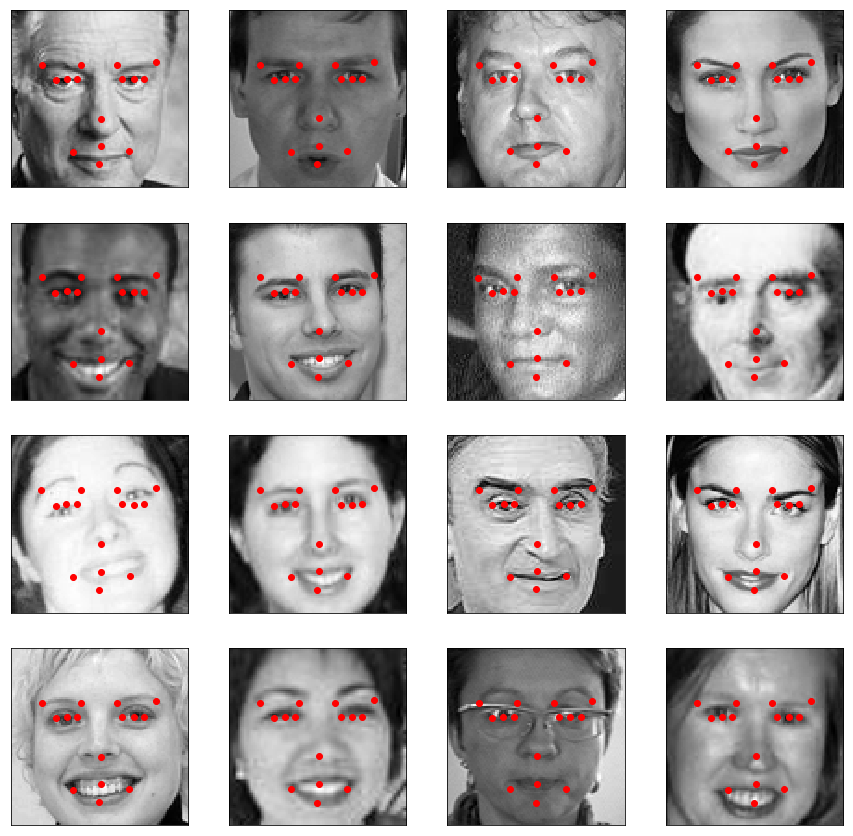

In [55]:
fig = plt.figure(figsize=(15,15))
# make test images keypoints prediction
points_test = model.predict(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_keypoints(imgs_test[i], np.squeeze(points_test[i]))

## References:
1. Dataset downloaded from Kaggle https://www.kaggle.com/c/facial-keypoints-detection